In [1]:
import pandas as pd
import numpy as np
import math
import glob
import yfinance as yf
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = glob.glob("*.csv")[0]
data_path

'all_stocks_5yr.csv'

In [4]:
delay = 252
window = 60
factor = 15
k = 252/window
sbo = 2
sso = 2
sbc = 0.75
ssc = 0.5
r = 0.03
tran_cost = 0.0005
leverage = 1
start_val = 100
name_pnl = 'pnl_r3_c05_d1'

In [5]:
data = pd.read_csv(data_path)
stocks = set(data['Name'])
stocks = list(stocks)
len(stocks)

505

In [6]:
if not os.path.isfile('data.pkl'):
    data = yf.download(stocks)
    data.to_pickle('data.pkl')
    print('data downloaded')
else:
    data = pd.read_pickle('data.pkl')
data = data['Adj Close']
fd = pd.Timestamp(2016, 1, 1, 12)
data = data[data.index > fd]
data = data = data.dropna(axis=1, how='any')

In [9]:
data.shape[1]

443

In [7]:
new_stocks = data.columns
s1 = yf.Ticker(new_stocks[0])
dps = s1.dividends
dps = pd.DataFrame(dps)

In [8]:
def get_dps(tickers):
    s1 = yf.Ticker(tickers[0])
    dps = s1.dividends
    dps = pd.DataFrame(dps)
    for s in tickers[1:]:
        tmp = yf.Ticker(s)
        tmp_dps = tmp.dividends
        dps = pd.concat([dps, tmp_dps],axis=1)
    dps.to_pickle('dps.pickle')
    return dps

In [9]:
if not os.path.isfile('dps.pkl'):
    dps = get_dps(new_stocks)
    dps.columns = new_stocks
    print('data downloaded')
else:
    dps = pd.read_pickle('dps.pkl')
    dps.columns= new_stocks
dps = dps[dps.index > fd]
dps = dps/data
dps = dps.fillna(0)

In [10]:
def find_Return(price):
    ret = (price - price.shift(1))/price
    ret = ret.drop(ret.index[0])
    # fill the nan values with 0
    ret = ret.fillna(value = 0)
    return ret

In [11]:
ret = find_Return(data)

In [12]:
def find_Factor(ret, delay, fac_num):
    # standardize the return
    mean = ret.mean(axis = 0)
    std = ret.std(axis = 0)
    std_ret = (ret - mean)/std
    
    #PCA process
    pca = PCA(n_components = fac_num)
    pca.fit(std_ret[0:delay])
    weight = pd.DataFrame(pca.components_)
    weight.columns = std.index
    weight = weight/std
    factor_ret = pd.DataFrame(np.dot(ret, weight.transpose()),index = ret.index)
    return factor_ret, weight

In [13]:
ret_fac, w = find_Factor(ret,30,15)
ret_fac

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Date,,,,,,,,,,,,,,,
2016-01-05,1.949039,-1.437557,3.663864,-3.587955,-3.877626,-0.764303,-1.697377,0.050145,-1.814319,0.620398,1.739876,-2.923615,-2.525131,0.985735,1.285778
2016-01-06,-17.197987,-6.011509,2.091933,-1.729960,0.832385,0.393466,-1.045700,-5.587959,-1.209996,-2.857163,0.214671,-0.379348,-2.333964,-2.588485,-0.401501
2016-01-07,-26.419599,-0.471305,1.192977,0.964335,-3.009198,0.116698,0.883371,1.552881,-4.159866,-1.247630,0.463827,-1.220028,6.992281,-3.658703,6.596496
2016-01-08,-12.231296,1.427288,-0.321702,2.190229,-3.090931,1.325914,-0.490748,-1.785733,2.857014,0.070494,2.663647,5.801288,-0.897182,-0.823171,-4.009979
2016-01-11,-3.555830,-4.400234,7.096039,-7.034748,6.032072,1.601009,-6.687826,-1.874046,-3.136303,-1.959265,-0.297148,6.386484,4.001629,-2.243660,-3.538514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-02,23.134164,0.579151,1.902334,-3.586399,1.758884,-0.027905,-1.541059,-0.619652,-3.651716,-0.677968,0.081214,0.607020,-1.095359,1.667456,0.604835
2021-12-03,-3.717735,1.423184,2.076321,-1.655604,-1.908206,-1.076202,-0.508732,-0.386638,2.647867,0.898909,0.962318,-0.322833,-1.778067,1.032878,-0.007316
2021-12-06,14.517255,0.348741,2.030673,-2.094227,0.787671,-1.132436,0.675411,-1.031151,-1.721914,-0.389236,0.612070,-1.197478,-0.070572,0.477931,-0.463849


In [14]:
def find_Residue(ret,ret_factorret):
    #storing the residues
    res = pd.DataFrame(columns = ret.columns, index = ret.index)
    coef = pd.DataFrame(columns = ret.columns, index = range(15))
    ols = LinearRegression()
    for i in ret.columns:
        ols.fit(ret_factorret, ret[i])
        res[i] = ret[i]-ols.intercept_-np.dot(ret_factorret, ols.coef_)
        coef[i] = ols.coef_
    return res,coef

In [15]:
res, coef = find_Residue(ret,ret_fac)

In [17]:
coef

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
0,0.001090,0.001578,0.000632,0.001014,0.000748,0.000846,0.000700,0.000922,0.001183,0.001186,...,0.000308,1.067286e-03,0.001002,0.001078,0.001396,0.000874,0.000797,0.001143,0.001163,0.000872
1,-0.001021,0.000849,-0.001969,-0.000127,-0.001051,-0.001382,-0.001481,-0.000638,-0.001887,0.000212,...,0.000076,1.482523e-07,0.002334,-0.000906,0.001023,0.000904,-0.000536,-0.001159,0.001915,-0.001474
2,-0.001203,-0.003387,0.001290,0.000914,-0.000779,-0.001003,-0.001751,0.000495,0.000967,-0.000733,...,0.001686,-6.639811e-04,0.000724,-0.001205,-0.001456,-0.000837,0.000217,-0.001555,-0.000895,-0.000230
3,-0.000132,-0.001635,-0.000258,0.000927,-0.000522,-0.000871,-0.001967,0.000708,0.002015,0.000375,...,-0.001065,7.823353e-04,0.000971,-0.000183,0.000119,-0.000598,0.000299,-0.000129,-0.001096,0.000198
4,0.000043,0.001516,0.001242,0.002108,-0.000466,-0.001106,-0.000280,0.000991,0.001263,0.001500,...,-0.001495,2.603175e-03,-0.000776,-0.001839,-0.001180,0.000999,-0.000208,-0.001224,0.000106,0.000095
5,0.000054,-0.001693,0.000040,-0.000762,-0.001783,-0.000676,-0.001106,0.000310,-0.000520,-0.000261,...,0.000772,-1.494241e-03,-0.001835,0.000359,-0.000904,0.000269,0.000281,-0.000776,0.001809,-0.000065
6,0.001656,-0.001478,-0.001436,-0.000517,0.001749,0.001478,0.000942,-0.000103,0.001274,-0.001207,...,-0.001042,-1.990385e-03,-0.000055,0.000588,-0.001407,-0.000378,-0.000279,0.000627,0.001781,0.000600
7,-0.000817,0.001351,0.001876,-0.002082,-0.000076,0.001297,-0.001192,-0.000768,-0.002052,-0.001168,...,-0.001310,-3.208115e-04,0.000056,0.000856,0.001379,-0.001209,0.000820,0.000898,0.000443,-0.000611
8,0.000404,-0.001623,-0.000498,0.001626,0.001120,0.002923,0.000797,-0.000159,-0.000620,0.000240,...,0.000442,1.194866e-03,-0.000173,0.000434,0.000119,-0.000734,-0.000511,-0.000704,-0.001087,0.000775
9,0.001050,-0.002979,0.001106,-0.001229,0.001341,0.000860,0.001803,0.000315,-0.000204,-0.000028,...,-0.000120,1.052109e-03,0.002035,-0.001032,-0.001990,0.001368,-0.000370,0.000480,-0.001612,0.001073


In [393]:
def find_Target_sscore(res, k):
    cum_res = res.cumsum()
    m = pd.Series(index = cum_res.columns)
    sigma_eq = pd.Series(index = cum_res.columns)
    for i in cum_res.columns:
        b = cum_res[i].autocorr()
        if -math.log(b) * 252 > k:
            temp = (cum_res[i]-cum_res[i].shift(1)* b)[1:]
            a = temp.mean()
            cosi =temp - a
            m[i] = a/(1-b)
            sigma_eq[i]=math.sqrt(cosi.var()/(1-b*b))
    m = m.dropna()
    m = m - m.mean()
    sigma_eq = sigma_eq.dropna()
    s_score = -m/sigma_eq
    return s_score

In [394]:
pnl = pd.Series(start_val, index = data.index[delay-1:])
position_stock = pd.DataFrame(0,columns = data.columns, index = ['stock']+list(np.arange(15)))
position_stock_before = pd.Series(0, index = data.columns)

In [395]:
for t in range(delay-1,len(data.index)-1):
    #find the window price of all stocks
    price_t = data[(t-window):(t+1)]
    # eliminate the nan
    price_t = price_t.dropna()
    #find the return of this period
    ret_t = find_Return(price_t)
    # find the residual of this period
    ret_fac_t = ret_fac[(t-window+1):(t+1)]
    res_t, coef_t = find_Residue(ret_t,ret_fac_t)
    # find the s-score of the target stocks of this period
    target = find_Target_sscore(res_t, k)
    # find the strategy for this time period:
    for i in position_stock.columns:
        if not i in target.index :
            if position_stock[i]['stock'] != 0:
                position_stock[i] = 0
        else:
            if position_stock[i]['stock'] == 0:
                if target[i] < -sbo:
                    position_stock[i]['stock'] = leverage
                    position_stock[i][1:] = -leverage * coef_t[i]
                elif target[i] > sso:
                    position_stock[i]['stock'] = - leverage
                    position_stock[i][1:] = leverage * coef_t[i]
            elif position_stock[i][0] >0 and target[i] > -ssc:
                position_stock[i] = 0
            elif position_stock[i][0] <0 and target[i] < sbc:
                position_stock[i] = 0
    # calculate the pnl for the next period
    dps_t = dps.iloc[t+1]
    pri_t = data.iloc[t+1]
    temp = (dps_t/pri_t).fillna(0)
    position_stock_temp = pd.Series(0,index = data.columns)
    fac_sum = position_stock.sum(axis = 1)[1:]
    for i in w.columns:
        position_stock_temp = sum(w[i] * fac_sum)
    position_stock_temp = position_stock_temp + position_stock.iloc[0]
    change = sum(abs(position_stock_temp - position_stock_before))
    position_stock_before = position_stock_temp
    pnl.iloc[t-delay + 2] = pnl.iloc[t-delay + 1] * ( 1 + r /252.0) + np.dot(position_stock.loc['stock'], ret.iloc[t]+temp) + np.dot(position_stock.sum(axis = 1)[1:], ret_fac.iloc[t]) - position_stock.sum().sum() * r /252.0 - change * tran_cost
    print(pnl.iloc[t-delay + 2])
pnl.to_pickle(name_pnl+'.pkl')
print(name_pnl+'.pkl created')

100.00602697218334
99.98923501649462
99.943203930467
99.94737891662783
99.9105476542082
99.96915673001901
100.06739547167773
100.04134588624278
100.09005042818661
100.0884016528408
100.15643348324134
100.05989145337352
100.02936724347212
99.81326163688979
99.81802163780843
99.70819156068767
99.72696231957195
99.73398507182429
99.95400331787796
99.65005746030788
99.47672674649077
98.97574801983231
99.08475053043016
99.3537471344838
99.35555464154781
99.29280192079482
99.47294531857379
99.4503688929662
99.57990771742234
99.74416441072118
99.56051634625453
99.56682347621872
99.53353945490629
99.76242688316933
99.66634158919057
99.62277681982684
99.62106001755072
99.7962121035352
99.93186271017636
100.20233024846644
100.25911498231929
100.1142477861921
100.05329319532821
99.88527576398162
99.59235771724481
99.70364735750564
99.83830122400923
99.88072024846775
99.70890343685701
100.14545034780015
100.00927074294589
100.08433409222008
100.21431828010307
100.23483228183544
100.21235588208954


105.69726555967982
105.70668170885254
105.7277907980667
105.71844855497426
105.71638359295456
105.63128983902116
105.59006006775539
105.26266238721394
105.27530740505364
105.67668013270857
106.19083215671697
106.22464056034053
106.0907899109397
106.05885099687755
105.99402687246716
106.01301735946387
105.83575157591541
105.9414555489869
106.02436994991902
106.22698935193688
106.71504927957794
107.90226910849606
107.96929590646938
107.61978445377642
107.69760812372833
107.56951512419651
107.69655182061486
107.6292770673508
107.65299273208431
107.4851576032423
107.6897365147835
107.80326997521101
107.81851256804211
107.73560037203039
107.66899489312306
107.9368902111288
107.89359547861977
107.65784087211742
107.59252615673259
107.89740311333989
107.7063175267709
107.80200455484567
107.9184054630614
108.01471746798049
108.19874336591224
107.97816456355655
107.92130953353723
107.8650018392786
107.99222673713253
107.69663334963337
107.29890283664366
106.94742880905075
106.97323389620489
106

117.26499451153242
117.11479876193972
117.12154349238948
117.1670390919807
117.29882692655082
117.32520105591375
117.48439987181912
117.50829689017938
117.60890461492856
117.54026439064293
117.62409320888396
117.60584789700195
117.44304124710958
117.47935707712752
117.55312698681871
117.57632720457168
117.52127586297883
117.63180664255813
117.76308045382608
117.72845341438055
117.67768465808962
117.60610721583197
117.60946532697301
117.63126214182454
117.60457590016394
117.61376988015994
117.6057638141975
117.849300909602
117.83563527920343
117.66895592372452
117.6639441652468
117.61449520977355
117.67724503459219
118.02004115099693
117.9128825469921
117.83230910720943
117.90777871193627
117.91591307406576
117.8506239300508
117.81802584020211
118.078923598993
118.05386513719723
118.09559082875685
118.13289618683577
118.12576501868264
118.11848573899789
118.14204527220475
118.34453771838669
117.79136322041781
118.12222068408751
117.07909598752472
116.85662618248448
115.94349453413447
11

In [400]:
def find_Sharpe_Ratio(pnl,r):
    mean = math.log(pnl.iloc[len(pnl.index)-1]/pnl.iloc[0])/(len(pnl.index)) * 252.0
    print(mean)
    ret = find_Return(pnl)
    std = ret.std() * math.sqrt(252)
    return (mean - r)/std

def find_Maximum_Drawdown(pnl):
    ret = find_Return(pnl)
    r = ret.add(1).cumprod()
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
#     end = dd.argmin()
#     start = r.loc[:end].argmax()
    return mdd

def find_Cumulative_Return(pnl):
    return (pnl.iloc[len(pnl.index)-1] - pnl.iloc[0]) / pnl.iloc[0]

In [401]:
sharpe_ratio = find_Sharpe_Ratio(pnl,r)
maximum_drawdowns = find_Maximum_Drawdown(pnl)
cumulative_return = find_Cumulative_Return(pnl)
sharpe_ratio, maximum_drawdowns, cumulative_return

0.030625226645457346


(0.007932622142848726, -0.08717761686421965, 0.1632079639871914)

In [402]:
import matplotlib.pyplot as plt

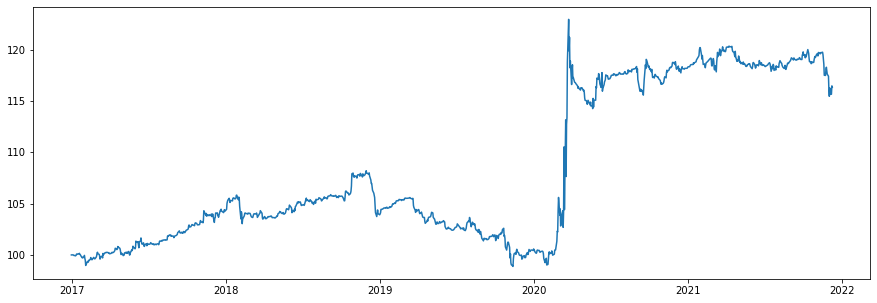

In [403]:
plt.figure(figsize=(15,5))
plt.plot(pnl)
plt.show()